## Instalando e Carregando Pacotes

In [1]:
#Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Projeto: ', python_version())

Versão da Linguagem Python Usada Neste Projeto:  3.9.12


In [2]:
#Instala o TensorFlow
!pip install -q tensorflow

In [3]:
#Instala o Pydot
!pip install -q pydot


In [4]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\jovanny.silva\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
#Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.10.0


## Carregando os Dados 

# Boston House Prices Dataset

Características:

- Os primeiros 13 recursos são preditivos numéricos / categóricos.
- O último (atributo 14): o valor mediano é a variável de destino.

In [6]:
#Download dos dados
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
dataset_path = keras.utils.get_file('housing.data','https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data')

In [7]:
nomes_colunas = ['CRIM',
                 'ZN',
                 'INDUS',
                 'CHAS',
                 'NOX',
                 'RM',
                 'AGE',
                 'DIS',
                 'RAD',
                 'TAX',
                 'PTTRATION',
                 'B',
                 'LSTAT',
                 'MEDV']

In [8]:
dataset = pd.read_csv(dataset_path,
                      names = nomes_colunas,
                      na_values = "?",
                      comment = '\t',
                     sep = " ",
                     skipinitialspace = True)

In [9]:
dataset.shape

(506, 14)

In [10]:
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTTRATION,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Vamos dividir os dados em treino e teste com proporção 80/20.

In [11]:
#Split dos dados
dados_treino = dataset.sample(frac = 0.8, random_state = 0)
dados_teste = dataset.drop(dados_treino.index)

## Modelagem Preditiva - Regressão Linear Simples

Na regressão linear simples desejamos modelar a relação entre a variável dependente (y) e uma variável independente (x).

- Variável independente: "RM"
- Variável dependente: "MEDV"

Queremos prever o valor da mediana das casas ocupadas por proprietários com base no número de quartos.

Criaremos um plot mostrando a relação entre as variáveis.

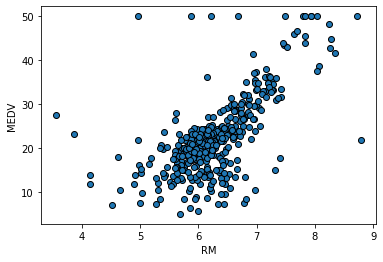

In [12]:
#Representação visual dos dados de treino
fig, ax = plt.subplots()
x = dados_treino ['RM']
y = dados_treino ['MEDV']
ax.scatter(x, y, edgecolors = (0, 0, 0))
ax.set_xlabel('RM')
ax.set_ylabel('MEDV')
plt.show()

Separando x e y

In [13]:
#Divisão
x_treino = dados_treino['RM']
y_treino = dados_treino['MEDV']
x_teste = dados_teste['RM']
y_teste = dados_teste['MEDV']

## Criação do Modelo

In [14]:
#Função para construir o modelo
def modelo_linear():
    
    #Cria o modelo
    model = keras.Sequential([layers.Dense(1, use_bias = True, input_shape = (1,), name = 'layer')])
    
    #Otimizador
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01,
                                         beta_1 = 0.9,
                                         beta_2 = 0.99,
                                         epsilon = 1e-05,
                                         amsgrad = False,
                                         name = 'Adam')
    
    #Complila o modelo
    model.compile(loss = 'mse',
                  optimizer = optimizer,
                  metrics = ['mae', 'mse'])
    
    return model

In [15]:
# Cria o modelo 
modelo = modelo_linear()

In [16]:
# Plot do modelo
tf.keras.utils.plot_model(modelo, 
                          to_file = 'imagens/modelo.png', 
                          show_shapes = True, 
                          show_layer_names = True,
                          rankdir = 'TB', 
                          expand_nested = False, 
                          dpi = 100)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Treinamento do Modelo

In [28]:
#Hiperparâmetros
n_epochs = 4000
batch_size = 256
n_idle_epochs = 100
n_epochs_log = 200
n_samples_save = n_epochs_log * x_treino.shape[0]
print('Checkpoint salvo a cada {} amostras'.format(n_samples_save))

Checkpoint salvo a cada 81000 amostras


In [19]:
#Callback
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience = n_idle_epochs,
                                                  min_delta = 0.001)

In [20]:
#Lista para as previsões
predictions_list = []

In [25]:
#Caminho para salvar o checkpoint
checkpoint_path = 'dados/'

In [22]:
#Criação de mais um callback para salvar o modelo após um período
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath = 'dados/',
                                                        verbose = 1,
                                                        save_weights_only = True,
                                                        save_freq = n_samples_save)

In [26]:
#Salva a primeira versão do modelo
modelo.save_weights(checkpoint_path.format(epoch = 0))

In [29]:
#Treinamento
history = modelo.fit(x_treino,
                     y_treino,
                     batch_size = batch_size,
                     epochs = n_epochs,
                     validation_split = 0.1,
                     verbose = 1,
                     callbacks = [earlyStopping, checkpointCallback])

Epoch 1/4000
2/2 [==============================] - 0s 157ms/step - loss: 391.7638 - mae: 17.9143 - mse: 391.7638 - val_loss: 469.8407 - val_mae: 19.1606 - val_mse: 469.8407
Epoch 2/4000
2/2 [==============================] - 0s 24ms/step - loss: 386.4228 - mae: 17.7688 - mse: 386.4228 - val_loss: 464.1606 - val_mae: 19.0149 - val_mse: 464.1606
Epoch 3/4000
2/2 [==============================] - 0s 26ms/step - loss: 381.1354 - mae: 17.6235 - mse: 381.1354 - val_loss: 458.5255 - val_mae: 18.8692 - val_mse: 458.5255
Epoch 4/4000
2/2 [==============================] - 0s 21ms/step - loss: 375.9094 - mae: 17.4787 - mse: 375.9094 - val_loss: 452.9390 - val_mae: 18.7236 - val_mse: 452.9390
Epoch 5/4000
2/2 [==============================] - 0s 21ms/step - loss: 370.6956 - mae: 17.3337 - mse: 370.6956 - val_loss: 447.4029 - val_mae: 18.5783 - val_mse: 447.4029
Epoch 6/4000
2/2 [==============================] - 0s 21ms/step - loss: 365.5959 - mae: 17.1890 - mse: 365.5959 - val_loss: 441.9183 

2/2 [==============================] - 0s 21ms/step - loss: 196.5935 - mae: 11.7202 - mse: 196.5935 - val_loss: 260.0182 - val_mae: 13.0244 - val_mse: 260.0182
Epoch 49/4000
2/2 [==============================] - 0s 21ms/step - loss: 193.6226 - mae: 11.6082 - mse: 193.6226 - val_loss: 256.8063 - val_mae: 12.9188 - val_mse: 256.8063
Epoch 50/4000
2/2 [==============================] - 0s 23ms/step - loss: 190.7363 - mae: 11.4968 - mse: 190.7363 - val_loss: 253.6316 - val_mae: 12.8136 - val_mse: 253.6316
Epoch 51/4000
2/2 [==============================] - 0s 22ms/step - loss: 187.8739 - mae: 11.3876 - mse: 187.8739 - val_loss: 250.4964 - val_mae: 12.7086 - val_mse: 250.4964
Epoch 52/4000
2/2 [==============================] - 0s 21ms/step - loss: 185.1004 - mae: 11.2780 - mse: 185.1004 - val_loss: 247.4023 - val_mae: 12.6040 - val_mse: 247.4023
Epoch 53/4000
2/2 [==============================] - 0s 22ms/step - loss: 182.2494 - mae: 11.1681 - mse: 182.2494 - val_loss: 244.3570 - val_mae

2/2 [==============================] - 0s 20ms/step - loss: 99.6964 - mae: 7.6192 - mse: 99.6964 - val_loss: 151.5103 - val_mae: 9.0819 - val_mse: 151.5103
Epoch 96/4000
2/2 [==============================] - 0s 20ms/step - loss: 98.4353 - mae: 7.5576 - mse: 98.4353 - val_loss: 150.0093 - val_mae: 9.0228 - val_mse: 150.0093
Epoch 97/4000
2/2 [==============================] - 0s 20ms/step - loss: 97.1879 - mae: 7.4989 - mse: 97.1879 - val_loss: 148.5383 - val_mae: 8.9641 - val_mse: 148.5383
Epoch 98/4000
2/2 [==============================] - 0s 20ms/step - loss: 95.9650 - mae: 7.4400 - mse: 95.9650 - val_loss: 147.1006 - val_mae: 8.9061 - val_mse: 147.1006
Epoch 99/4000
2/2 [==============================] - 0s 20ms/step - loss: 94.7420 - mae: 7.3814 - mse: 94.7420 - val_loss: 145.6953 - val_mae: 8.8502 - val_mse: 145.6953
Epoch 100/4000
2/2 [==============================] - 0s 20ms/step - loss: 93.6121 - mae: 7.3253 - mse: 93.6121 - val_loss: 144.3160 - val_mae: 8.7970 - val_mse: 14

2/2 [==============================] - 0s 20ms/step - loss: 63.0039 - mae: 5.6251 - mse: 63.0039 - val_loss: 106.1945 - val_mae: 7.2323 - val_mse: 106.1945
Epoch 144/4000
2/2 [==============================] - 0s 20ms/step - loss: 62.6386 - mae: 5.6039 - mse: 62.6386 - val_loss: 105.7102 - val_mae: 7.2113 - val_mse: 105.7102
Epoch 145/4000
2/2 [==============================] - 0s 21ms/step - loss: 62.3101 - mae: 5.5836 - mse: 62.3101 - val_loss: 105.2371 - val_mae: 7.1904 - val_mse: 105.2371
Epoch 146/4000
2/2 [==============================] - 0s 20ms/step - loss: 61.9805 - mae: 5.5658 - mse: 61.9805 - val_loss: 104.7776 - val_mae: 7.1704 - val_mse: 104.7776
Epoch 147/4000
2/2 [==============================] - 0s 21ms/step - loss: 61.6663 - mae: 5.5473 - mse: 61.6663 - val_loss: 104.3295 - val_mae: 7.1528 - val_mse: 104.3295
Epoch 148/4000
2/2 [==============================] - 0s 21ms/step - loss: 61.3715 - mae: 5.5310 - mse: 61.3715 - val_loss: 103.8933 - val_mae: 7.1353 - val_mse

2/2 [==============================] - 0s 23ms/step - loss: 55.3586 - mae: 5.2436 - mse: 55.3586 - val_loss: 93.7591 - val_mae: 6.7946 - val_mse: 93.7591
Epoch 192/4000
2/2 [==============================] - 0s 21ms/step - loss: 55.3272 - mae: 5.2442 - mse: 55.3272 - val_loss: 93.6689 - val_mae: 6.7931 - val_mse: 93.6689
Epoch 193/4000
2/2 [==============================] - 0s 23ms/step - loss: 55.2920 - mae: 5.2447 - mse: 55.2920 - val_loss: 93.5864 - val_mae: 6.7917 - val_mse: 93.5864
Epoch 194/4000
2/2 [==============================] - 0s 20ms/step - loss: 55.2472 - mae: 5.2443 - mse: 55.2472 - val_loss: 93.5061 - val_mae: 6.7903 - val_mse: 93.5061
Epoch 195/4000
2/2 [==============================] - 0s 23ms/step - loss: 55.2241 - mae: 5.2447 - mse: 55.2241 - val_loss: 93.4152 - val_mae: 6.7887 - val_mse: 93.4152
Epoch 196/4000
2/2 [==============================] - 0s 20ms/step - loss: 55.2002 - mae: 5.2462 - mse: 55.2002 - val_loss: 93.3252 - val_mae: 6.7878 - val_mse: 93.3252
E

2/2 [==============================] - 0s 23ms/step - loss: 54.7744 - mae: 5.2875 - mse: 54.7744 - val_loss: 91.6767 - val_mae: 6.7757 - val_mse: 91.6767
Epoch 240/4000
2/2 [==============================] - 0s 24ms/step - loss: 54.7741 - mae: 5.2880 - mse: 54.7741 - val_loss: 91.6710 - val_mae: 6.7755 - val_mse: 91.6710
Epoch 241/4000
2/2 [==============================] - 0s 26ms/step - loss: 54.7694 - mae: 5.2878 - mse: 54.7694 - val_loss: 91.6742 - val_mae: 6.7754 - val_mse: 91.6742
Epoch 242/4000
2/2 [==============================] - 0s 24ms/step - loss: 54.7675 - mae: 5.2875 - mse: 54.7675 - val_loss: 91.6801 - val_mae: 6.7754 - val_mse: 91.6801
Epoch 243/4000
2/2 [==============================] - 0s 22ms/step - loss: 54.7650 - mae: 5.2869 - mse: 54.7650 - val_loss: 91.6914 - val_mae: 6.7753 - val_mse: 91.6914
Epoch 244/4000
2/2 [==============================] - 0s 23ms/step - loss: 54.7632 - mae: 5.2860 - mse: 54.7632 - val_loss: 91.7029 - val_mae: 6.7753 - val_mse: 91.7029
E

2/2 [==============================] - 0s 20ms/step - loss: 54.6471 - mae: 5.2835 - mse: 54.6471 - val_loss: 91.5343 - val_mae: 6.7683 - val_mse: 91.5343
Epoch 288/4000
2/2 [==============================] - 0s 19ms/step - loss: 54.6443 - mae: 5.2836 - mse: 54.6443 - val_loss: 91.5223 - val_mae: 6.7680 - val_mse: 91.5223
Epoch 289/4000
2/2 [==============================] - 0s 19ms/step - loss: 54.6394 - mae: 5.2842 - mse: 54.6394 - val_loss: 91.4986 - val_mae: 6.7677 - val_mse: 91.4986
Epoch 290/4000
2/2 [==============================] - 0s 21ms/step - loss: 54.6407 - mae: 5.2855 - mse: 54.6407 - val_loss: 91.4766 - val_mae: 6.7674 - val_mse: 91.4766
Epoch 291/4000
2/2 [==============================] - 0s 22ms/step - loss: 54.6341 - mae: 5.2862 - mse: 54.6341 - val_loss: 91.4670 - val_mae: 6.7671 - val_mse: 91.4670
Epoch 292/4000
2/2 [==============================] - 0s 23ms/step - loss: 54.6334 - mae: 5.2866 - mse: 54.6334 - val_loss: 91.4636 - val_mae: 6.7670 - val_mse: 91.4636
E

2/2 [==============================] - 0s 22ms/step - loss: 54.4577 - mae: 5.2805 - mse: 54.4577 - val_loss: 91.2742 - val_mae: 6.7566 - val_mse: 91.2742
Epoch 336/4000
2/2 [==============================] - 0s 21ms/step - loss: 54.4529 - mae: 5.2804 - mse: 54.4529 - val_loss: 91.2736 - val_mae: 6.7564 - val_mse: 91.2736
Epoch 337/4000
2/2 [==============================] - 0s 21ms/step - loss: 54.4474 - mae: 5.2798 - mse: 54.4474 - val_loss: 91.2801 - val_mae: 6.7561 - val_mse: 91.2801
Epoch 338/4000
2/2 [==============================] - 0s 20ms/step - loss: 54.4431 - mae: 5.2787 - mse: 54.4431 - val_loss: 91.2900 - val_mae: 6.7559 - val_mse: 91.2900
Epoch 339/4000
2/2 [==============================] - 0s 21ms/step - loss: 54.4377 - mae: 5.2777 - mse: 54.4377 - val_loss: 91.2944 - val_mae: 6.7557 - val_mse: 91.2944
Epoch 340/4000
2/2 [==============================] - 0s 21ms/step - loss: 54.4319 - mae: 5.2769 - mse: 54.4319 - val_loss: 91.2946 - val_mae: 6.7554 - val_mse: 91.2946
E

2/2 [==============================] - 0s 23ms/step - loss: 54.1970 - mae: 5.2461 - mse: 54.1970 - val_loss: 91.3843 - val_mae: 6.7431 - val_mse: 91.3843
Epoch 384/4000
2/2 [==============================] - 0s 21ms/step - loss: 54.1928 - mae: 5.2477 - mse: 54.1928 - val_loss: 91.3323 - val_mae: 6.7424 - val_mse: 91.3323
Epoch 385/4000
2/2 [==============================] - 0s 23ms/step - loss: 54.1814 - mae: 5.2497 - mse: 54.1814 - val_loss: 91.2954 - val_mae: 6.7419 - val_mse: 91.2954
Epoch 386/4000
2/2 [==============================] - 0s 20ms/step - loss: 54.1749 - mae: 5.2512 - mse: 54.1749 - val_loss: 91.2696 - val_mae: 6.7413 - val_mse: 91.2696
Epoch 387/4000
2/2 [==============================] - 0s 20ms/step - loss: 54.1642 - mae: 5.2516 - mse: 54.1642 - val_loss: 91.2581 - val_mae: 6.7409 - val_mse: 91.2581
Epoch 388/4000
2/2 [==============================] - 0s 21ms/step - loss: 54.1574 - mae: 5.2515 - mse: 54.1574 - val_loss: 91.2432 - val_mae: 6.7405 - val_mse: 91.2432
E

2/2 [==============================] - 0s 23ms/step - loss: 53.8541 - mae: 5.2241 - mse: 53.8541 - val_loss: 91.2529 - val_mae: 6.7236 - val_mse: 91.2529
Epoch 432/4000
2/2 [==============================] - 0s 22ms/step - loss: 53.8523 - mae: 5.2218 - mse: 53.8523 - val_loss: 91.2925 - val_mae: 6.7235 - val_mse: 91.2925
Epoch 433/4000
2/2 [==============================] - 0s 20ms/step - loss: 53.8486 - mae: 5.2196 - mse: 53.8486 - val_loss: 91.3004 - val_mae: 6.7231 - val_mse: 91.3004
Epoch 434/4000
2/2 [==============================] - 0s 24ms/step - loss: 53.8419 - mae: 5.2188 - mse: 53.8419 - val_loss: 91.2767 - val_mae: 6.7225 - val_mse: 91.2767
Epoch 435/4000
2/2 [==============================] - 0s 21ms/step - loss: 53.8310 - mae: 5.2193 - mse: 53.8310 - val_loss: 91.2250 - val_mae: 6.7218 - val_mse: 91.2250
Epoch 436/4000
2/2 [==============================] - 0s 20ms/step - loss: 53.8168 - mae: 5.2210 - mse: 53.8168 - val_loss: 91.1638 - val_mae: 6.7210 - val_mse: 91.1638
E

2/2 [==============================] - 0s 20ms/step - loss: 53.4540 - mae: 5.2075 - mse: 53.4540 - val_loss: 90.8336 - val_mae: 6.6999 - val_mse: 90.8336
Epoch 480/4000
2/2 [==============================] - 0s 21ms/step - loss: 53.4481 - mae: 5.2060 - mse: 53.4481 - val_loss: 90.8495 - val_mae: 6.6995 - val_mse: 90.8495
Epoch 481/4000
2/2 [==============================] - 0s 20ms/step - loss: 53.4464 - mae: 5.2052 - mse: 53.4464 - val_loss: 90.8550 - val_mae: 6.6991 - val_mse: 90.8550
Epoch 482/4000
2/2 [==============================] - 0s 20ms/step - loss: 53.4376 - mae: 5.2034 - mse: 53.4376 - val_loss: 90.8862 - val_mae: 6.6989 - val_mse: 90.8862
Epoch 483/4000
2/2 [==============================] - 0s 21ms/step - loss: 53.4280 - mae: 5.2016 - mse: 53.4280 - val_loss: 90.8818 - val_mae: 6.6984 - val_mse: 90.8818
Epoch 484/4000
2/2 [==============================] - 0s 21ms/step - loss: 53.4239 - mae: 5.2014 - mse: 53.4239 - val_loss: 90.8751 - val_mae: 6.6979 - val_mse: 90.8751
E

2/2 [==============================] - 0s 20ms/step - loss: 53.0499 - mae: 5.1972 - mse: 53.0499 - val_loss: 90.2605 - val_mae: 6.6741 - val_mse: 90.2605
Epoch 528/4000
2/2 [==============================] - 0s 21ms/step - loss: 53.0424 - mae: 5.2007 - mse: 53.0424 - val_loss: 90.2103 - val_mae: 6.6733 - val_mse: 90.2103
Epoch 529/4000
2/2 [==============================] - 0s 21ms/step - loss: 53.0388 - mae: 5.2033 - mse: 53.0388 - val_loss: 90.1743 - val_mae: 6.6726 - val_mse: 90.1743
Epoch 530/4000
2/2 [==============================] - 0s 22ms/step - loss: 53.0299 - mae: 5.2045 - mse: 53.0299 - val_loss: 90.1600 - val_mae: 6.6720 - val_mse: 90.1600
Epoch 531/4000
2/2 [==============================] - 0s 20ms/step - loss: 53.0223 - mae: 5.2045 - mse: 53.0223 - val_loss: 90.1540 - val_mae: 6.6715 - val_mse: 90.1540
Epoch 532/4000
2/2 [==============================] - 0s 21ms/step - loss: 53.0141 - mae: 5.2040 - mse: 53.0141 - val_loss: 90.1477 - val_mae: 6.6710 - val_mse: 90.1477
E

2/2 [==============================] - 0s 23ms/step - loss: 52.6448 - mae: 5.1865 - mse: 52.6448 - val_loss: 89.8468 - val_mae: 6.6480 - val_mse: 89.8468
Epoch 576/4000
2/2 [==============================] - 0s 20ms/step - loss: 52.6427 - mae: 5.1842 - mse: 52.6427 - val_loss: 89.8747 - val_mae: 6.6477 - val_mse: 89.8747
Epoch 577/4000
2/2 [==============================] - 0s 20ms/step - loss: 52.6258 - mae: 5.1813 - mse: 52.6258 - val_loss: 89.8721 - val_mae: 6.6472 - val_mse: 89.8721
Epoch 578/4000
2/2 [==============================] - 0s 21ms/step - loss: 52.6130 - mae: 5.1806 - mse: 52.6130 - val_loss: 89.8487 - val_mae: 6.6465 - val_mse: 89.8487
Epoch 579/4000
2/2 [==============================] - 0s 20ms/step - loss: 52.6132 - mae: 5.1819 - mse: 52.6132 - val_loss: 89.8298 - val_mae: 6.6459 - val_mse: 89.8298
Epoch 580/4000
2/2 [==============================] - 0s 21ms/step - loss: 52.6008 - mae: 5.1812 - mse: 52.6008 - val_loss: 89.8476 - val_mae: 6.6455 - val_mse: 89.8476
E

2/2 [==============================] - 0s 20ms/step - loss: 52.2514 - mae: 5.1564 - mse: 52.2514 - val_loss: 89.7035 - val_mae: 6.6253 - val_mse: 89.7035
Epoch 624/4000
2/2 [==============================] - 0s 20ms/step - loss: 52.2448 - mae: 5.1519 - mse: 52.2448 - val_loss: 89.7693 - val_mae: 6.6253 - val_mse: 89.7693
Epoch 625/4000
2/2 [==============================] - 0s 20ms/step - loss: 52.2318 - mae: 5.1467 - mse: 52.2318 - val_loss: 89.8247 - val_mae: 6.6253 - val_mse: 89.8247
Epoch 626/4000
2/2 [==============================] - 0s 20ms/step - loss: 52.2257 - mae: 5.1426 - mse: 52.2257 - val_loss: 89.8807 - val_mae: 6.6252 - val_mse: 89.8807
Epoch 627/4000
2/2 [==============================] - 0s 21ms/step - loss: 52.2196 - mae: 5.1387 - mse: 52.2196 - val_loss: 89.9241 - val_mae: 6.6250 - val_mse: 89.9241
Epoch 628/4000
2/2 [==============================] - 0s 20ms/step - loss: 52.2131 - mae: 5.1358 - mse: 52.2131 - val_loss: 89.9545 - val_mae: 6.6248 - val_mse: 89.9545
E

2/2 [==============================] - 0s 21ms/step - loss: 51.8799 - mae: 5.1058 - mse: 51.8799 - val_loss: 89.8997 - val_mae: 6.6038 - val_mse: 89.8997
Epoch 672/4000
2/2 [==============================] - 0s 21ms/step - loss: 51.8714 - mae: 5.1044 - mse: 51.8714 - val_loss: 89.8625 - val_mae: 6.6031 - val_mse: 89.8625
Epoch 673/4000
2/2 [==============================] - 0s 20ms/step - loss: 51.8636 - mae: 5.1055 - mse: 51.8636 - val_loss: 89.7796 - val_mae: 6.6021 - val_mse: 89.7796
Epoch 674/4000
2/2 [==============================] - 0s 20ms/step - loss: 51.8391 - mae: 5.1083 - mse: 51.8391 - val_loss: 89.7159 - val_mae: 6.6012 - val_mse: 89.7159
Epoch 675/4000
2/2 [==============================] - 0s 20ms/step - loss: 51.8284 - mae: 5.1106 - mse: 51.8284 - val_loss: 89.6359 - val_mae: 6.6002 - val_mse: 89.6359
Epoch 676/4000
2/2 [==============================] - 0s 21ms/step - loss: 51.8124 - mae: 5.1134 - mse: 51.8124 - val_loss: 89.5585 - val_mae: 6.5991 - val_mse: 89.5585
E

2/2 [==============================] - 0s 20ms/step - loss: 51.4606 - mae: 5.0884 - mse: 51.4606 - val_loss: 89.4323 - val_mae: 6.5770 - val_mse: 89.4323
Epoch 720/4000
2/2 [==============================] - 0s 21ms/step - loss: 51.4513 - mae: 5.0888 - mse: 51.4513 - val_loss: 89.3967 - val_mae: 6.5763 - val_mse: 89.3967
Epoch 721/4000
2/2 [==============================] - 0s 19ms/step - loss: 51.4526 - mae: 5.0903 - mse: 51.4526 - val_loss: 89.3673 - val_mae: 6.5756 - val_mse: 89.3673
Epoch 722/4000
2/2 [==============================] - 0s 21ms/step - loss: 51.4328 - mae: 5.0902 - mse: 51.4328 - val_loss: 89.3819 - val_mae: 6.5752 - val_mse: 89.3819
Epoch 723/4000
2/2 [==============================] - 0s 21ms/step - loss: 51.4256 - mae: 5.0885 - mse: 51.4256 - val_loss: 89.4074 - val_mae: 6.5749 - val_mse: 89.4074
Epoch 724/4000
2/2 [==============================] - 0s 26ms/step - loss: 51.4191 - mae: 5.0866 - mse: 51.4191 - val_loss: 89.4237 - val_mae: 6.5745 - val_mse: 89.4237
E

2/2 [==============================] - 0s 20ms/step - loss: 51.0953 - mae: 5.0875 - mse: 51.0953 - val_loss: 88.8368 - val_mae: 6.5506 - val_mse: 88.8368
Epoch 768/4000
2/2 [==============================] - 0s 19ms/step - loss: 51.0855 - mae: 5.0851 - mse: 51.0855 - val_loss: 88.8623 - val_mae: 6.5503 - val_mse: 88.8623
Epoch 769/4000
2/2 [==============================] - 0s 22ms/step - loss: 51.0756 - mae: 5.0828 - mse: 51.0756 - val_loss: 88.8853 - val_mae: 6.5500 - val_mse: 88.8853
Epoch 770/4000
2/2 [==============================] - 0s 22ms/step - loss: 51.0655 - mae: 5.0805 - mse: 51.0655 - val_loss: 88.9102 - val_mae: 6.5498 - val_mse: 88.9102
Epoch 771/4000
2/2 [==============================] - 0s 20ms/step - loss: 51.0567 - mae: 5.0782 - mse: 51.0567 - val_loss: 88.9463 - val_mae: 6.5496 - val_mse: 88.9463
Epoch 772/4000
2/2 [==============================] - 0s 21ms/step - loss: 51.0471 - mae: 5.0748 - mse: 51.0471 - val_loss: 89.0106 - val_mae: 6.5496 - val_mse: 89.0106
E

2/2 [==============================] - 0s 20ms/step - loss: 50.7286 - mae: 5.0503 - mse: 50.7286 - val_loss: 88.7680 - val_mae: 6.5284 - val_mse: 88.7680
Epoch 816/4000
2/2 [==============================] - 0s 21ms/step - loss: 50.7206 - mae: 5.0529 - mse: 50.7206 - val_loss: 88.7071 - val_mae: 6.5275 - val_mse: 88.7071
Epoch 817/4000
2/2 [==============================] - 0s 21ms/step - loss: 50.7133 - mae: 5.0557 - mse: 50.7133 - val_loss: 88.6407 - val_mae: 6.5266 - val_mse: 88.6407
Epoch 818/4000
2/2 [==============================] - 0s 20ms/step - loss: 50.7071 - mae: 5.0589 - mse: 50.7071 - val_loss: 88.5676 - val_mae: 6.5256 - val_mse: 88.5676
Epoch 819/4000
2/2 [==============================] - 0s 20ms/step - loss: 50.7091 - mae: 5.0633 - mse: 50.7091 - val_loss: 88.4922 - val_mae: 6.5262 - val_mse: 88.4922
Epoch 820/4000
2/2 [==============================] - 0s 21ms/step - loss: 50.7136 - mae: 5.0676 - mse: 50.7136 - val_loss: 88.4419 - val_mae: 6.5265 - val_mse: 88.4419
E

2/2 [==============================] - 0s 20ms/step - loss: 50.3721 - mae: 5.0225 - mse: 50.3721 - val_loss: 88.6847 - val_mae: 6.5052 - val_mse: 88.6847
Epoch 864/4000
2/2 [==============================] - 0s 20ms/step - loss: 50.3650 - mae: 5.0216 - mse: 50.3650 - val_loss: 88.6920 - val_mae: 6.5047 - val_mse: 88.6920
Epoch 865/4000
2/2 [==============================] - 0s 21ms/step - loss: 50.3582 - mae: 5.0204 - mse: 50.3582 - val_loss: 88.7017 - val_mae: 6.5043 - val_mse: 88.7017
Epoch 866/4000
2/2 [==============================] - 0s 20ms/step - loss: 50.3516 - mae: 5.0193 - mse: 50.3516 - val_loss: 88.7115 - val_mae: 6.5039 - val_mse: 88.7115
Epoch 867/4000
2/2 [==============================] - 0s 20ms/step - loss: 50.3496 - mae: 5.0180 - mse: 50.3496 - val_loss: 88.7136 - val_mae: 6.5034 - val_mse: 88.7136
Epoch 868/4000
2/2 [==============================] - 0s 21ms/step - loss: 50.3358 - mae: 5.0175 - mse: 50.3358 - val_loss: 88.6673 - val_mae: 6.5026 - val_mse: 88.6673
E

2/2 [==============================] - 0s 20ms/step - loss: 50.0048 - mae: 5.0113 - mse: 50.0048 - val_loss: 88.1688 - val_mae: 6.4784 - val_mse: 88.1688
Epoch 912/4000
2/2 [==============================] - 0s 21ms/step - loss: 50.0014 - mae: 5.0138 - mse: 50.0014 - val_loss: 88.1338 - val_mae: 6.4784 - val_mse: 88.1338
Epoch 913/4000
2/2 [==============================] - 0s 19ms/step - loss: 50.0057 - mae: 5.0157 - mse: 50.0057 - val_loss: 88.1336 - val_mae: 6.4779 - val_mse: 88.1336
Epoch 914/4000
2/2 [==============================] - 0s 20ms/step - loss: 49.9841 - mae: 5.0135 - mse: 49.9841 - val_loss: 88.1904 - val_mae: 6.4768 - val_mse: 88.1904
Epoch 915/4000
2/2 [==============================] - 0s 20ms/step - loss: 49.9766 - mae: 5.0091 - mse: 49.9766 - val_loss: 88.2477 - val_mae: 6.4768 - val_mse: 88.2477
Epoch 916/4000
2/2 [==============================] - 0s 21ms/step - loss: 49.9695 - mae: 5.0050 - mse: 49.9695 - val_loss: 88.2905 - val_mae: 6.4766 - val_mse: 88.2905
E

2/2 [==============================] - 0s 22ms/step - loss: 49.6804 - mae: 4.9912 - mse: 49.6804 - val_loss: 87.9510 - val_mae: 6.4566 - val_mse: 87.9510
Epoch 960/4000
2/2 [==============================] - 0s 20ms/step - loss: 49.6730 - mae: 4.9928 - mse: 49.6730 - val_loss: 87.9331 - val_mae: 6.4564 - val_mse: 87.9331
Epoch 961/4000
2/2 [==============================] - 0s 21ms/step - loss: 49.6670 - mae: 4.9931 - mse: 49.6670 - val_loss: 87.9344 - val_mae: 6.4558 - val_mse: 87.9344
Epoch 962/4000
2/2 [==============================] - 0s 21ms/step - loss: 49.6587 - mae: 4.9921 - mse: 49.6587 - val_loss: 87.9535 - val_mae: 6.4550 - val_mse: 87.9535
Epoch 963/4000
2/2 [==============================] - 0s 20ms/step - loss: 49.6501 - mae: 4.9902 - mse: 49.6501 - val_loss: 87.9778 - val_mae: 6.4541 - val_mse: 87.9778
Epoch 964/4000
2/2 [==============================] - 0s 20ms/step - loss: 49.6412 - mae: 4.9879 - mse: 49.6412 - val_loss: 88.0100 - val_mae: 6.4534 - val_mse: 88.0100
E

2/2 [==============================] - 0s 20ms/step - loss: 49.3521 - mae: 4.9582 - mse: 49.3521 - val_loss: 87.9839 - val_mae: 6.4341 - val_mse: 87.9839
Epoch 1008/4000
2/2 [==============================] - 0s 20ms/step - loss: 49.3451 - mae: 4.9591 - mse: 49.3451 - val_loss: 87.9541 - val_mae: 6.4331 - val_mse: 87.9541
Epoch 1009/4000
2/2 [==============================] - 0s 21ms/step - loss: 49.3365 - mae: 4.9595 - mse: 49.3365 - val_loss: 87.9343 - val_mae: 6.4325 - val_mse: 87.9343
Epoch 1010/4000
2/2 [==============================] - 0s 21ms/step - loss: 49.3293 - mae: 4.9598 - mse: 49.3293 - val_loss: 87.9080 - val_mae: 6.4319 - val_mse: 87.9080
Epoch 1011/4000
2/2 [==============================] - 0s 20ms/step - loss: 49.3232 - mae: 4.9602 - mse: 49.3232 - val_loss: 87.8700 - val_mae: 6.4311 - val_mse: 87.8700
Epoch 1012/4000
2/2 [==============================] - 0s 20ms/step - loss: 49.3161 - mae: 4.9621 - mse: 49.3161 - val_loss: 87.8022 - val_mae: 6.4308 - val_mse: 87.8

2/2 [==============================] - 0s 20ms/step - loss: 49.0209 - mae: 4.9446 - mse: 49.0209 - val_loss: 87.6180 - val_mae: 6.4117 - val_mse: 87.6180
Epoch 1056/4000
2/2 [==============================] - 0s 22ms/step - loss: 49.0146 - mae: 4.9448 - mse: 49.0146 - val_loss: 87.6041 - val_mae: 6.4113 - val_mse: 87.6041
Epoch 1057/4000
2/2 [==============================] - 0s 20ms/step - loss: 49.0084 - mae: 4.9447 - mse: 49.0084 - val_loss: 87.5919 - val_mae: 6.4109 - val_mse: 87.5919
Epoch 1058/4000
2/2 [==============================] - 0s 21ms/step - loss: 49.0017 - mae: 4.9452 - mse: 49.0017 - val_loss: 87.5666 - val_mae: 6.4104 - val_mse: 87.5666
Epoch 1059/4000
2/2 [==============================] - 0s 19ms/step - loss: 48.9943 - mae: 4.9454 - mse: 48.9943 - val_loss: 87.5583 - val_mae: 6.4100 - val_mse: 87.5583
Epoch 1060/4000
2/2 [==============================] - 0s 21ms/step - loss: 48.9874 - mae: 4.9449 - mse: 48.9874 - val_loss: 87.5561 - val_mae: 6.4096 - val_mse: 87.5

2/2 [==============================] - 0s 20ms/step - loss: 48.7366 - mae: 4.9475 - mse: 48.7366 - val_loss: 87.0569 - val_mae: 6.3929 - val_mse: 87.0569
Epoch 1104/4000
2/2 [==============================] - 0s 21ms/step - loss: 48.7258 - mae: 4.9456 - mse: 48.7258 - val_loss: 87.0909 - val_mae: 6.3920 - val_mse: 87.0909
Epoch 1105/4000
2/2 [==============================] - 0s 20ms/step - loss: 48.7175 - mae: 4.9424 - mse: 48.7175 - val_loss: 87.1440 - val_mae: 6.3919 - val_mse: 87.1440
Epoch 1106/4000
2/2 [==============================] - 0s 21ms/step - loss: 48.6954 - mae: 4.9375 - mse: 48.6954 - val_loss: 87.1958 - val_mae: 6.3917 - val_mse: 87.1958
Epoch 1107/4000
2/2 [==============================] - 0s 20ms/step - loss: 48.6849 - mae: 4.9333 - mse: 48.6849 - val_loss: 87.2700 - val_mae: 6.3916 - val_mse: 87.2700
Epoch 1108/4000
2/2 [==============================] - 0s 20ms/step - loss: 48.6747 - mae: 4.9272 - mse: 48.6747 - val_loss: 87.3396 - val_mae: 6.3916 - val_mse: 87.3

2/2 [==============================] - 0s 21ms/step - loss: 48.4086 - mae: 4.8988 - mse: 48.4086 - val_loss: 87.3171 - val_mae: 6.3813 - val_mse: 87.3171
Epoch 1152/4000
2/2 [==============================] - 0s 19ms/step - loss: 48.3982 - mae: 4.8998 - mse: 48.3982 - val_loss: 87.2510 - val_mae: 6.3795 - val_mse: 87.2510
Epoch 1153/4000
2/2 [==============================] - 0s 20ms/step - loss: 48.3971 - mae: 4.9031 - mse: 48.3971 - val_loss: 87.1898 - val_mae: 6.3779 - val_mse: 87.1898
Epoch 1154/4000
2/2 [==============================] - 0s 20ms/step - loss: 48.4060 - mae: 4.9060 - mse: 48.4060 - val_loss: 87.1652 - val_mae: 6.3771 - val_mse: 87.1652
Epoch 1155/4000
2/2 [==============================] - 0s 21ms/step - loss: 48.3833 - mae: 4.9046 - mse: 48.3833 - val_loss: 87.1994 - val_mae: 6.3776 - val_mse: 87.1994
Epoch 1156/4000
2/2 [==============================] - 0s 20ms/step - loss: 48.3769 - mae: 4.9025 - mse: 48.3769 - val_loss: 87.2311 - val_mae: 6.3781 - val_mse: 87.2

2/2 [==============================] - 0s 20ms/step - loss: 48.1191 - mae: 4.8890 - mse: 48.1191 - val_loss: 86.9972 - val_mae: 6.3624 - val_mse: 86.9972
Epoch 1200/4000
2/2 [==============================] - 0s 20ms/step - loss: 48.1026 - mae: 4.8854 - mse: 48.1026 - val_loss: 87.0419 - val_mae: 6.3632 - val_mse: 87.0419
Epoch 1201/4000
2/2 [==============================] - 0s 21ms/step - loss: 48.0947 - mae: 4.8825 - mse: 48.0947 - val_loss: 87.1050 - val_mae: 6.3644 - val_mse: 87.1050
Epoch 1202/4000
2/2 [==============================] - 0s 21ms/step - loss: 48.0885 - mae: 4.8789 - mse: 48.0885 - val_loss: 87.1755 - val_mae: 6.3657 - val_mse: 87.1755
Epoch 1203/4000
2/2 [==============================] - 0s 23ms/step - loss: 48.0857 - mae: 4.8751 - mse: 48.0857 - val_loss: 87.2452 - val_mae: 6.3676 - val_mse: 87.2452
Epoch 1204/4000
2/2 [==============================] - 0s 20ms/step - loss: 48.0811 - mae: 4.8719 - mse: 48.0811 - val_loss: 87.3046 - val_mae: 6.3699 - val_mse: 87.3

2/2 [==============================] - 0s 20ms/step - loss: 47.8368 - mae: 4.8717 - mse: 47.8368 - val_loss: 86.7963 - val_mae: 6.3466 - val_mse: 86.7963
Epoch 1248/4000
2/2 [==============================] - 0s 20ms/step - loss: 47.8256 - mae: 4.8676 - mse: 47.8256 - val_loss: 86.8578 - val_mae: 6.3478 - val_mse: 86.8578
Epoch 1249/4000
2/2 [==============================] - 0s 21ms/step - loss: 47.8226 - mae: 4.8642 - mse: 47.8226 - val_loss: 86.9251 - val_mae: 6.3491 - val_mse: 86.9251
Epoch 1250/4000
2/2 [==============================] - 0s 22ms/step - loss: 47.8181 - mae: 4.8604 - mse: 47.8181 - val_loss: 86.9685 - val_mae: 6.3499 - val_mse: 86.9685
Epoch 1251/4000
2/2 [==============================] - 0s 19ms/step - loss: 47.8081 - mae: 4.8581 - mse: 47.8081 - val_loss: 86.9858 - val_mae: 6.3500 - val_mse: 86.9858
Epoch 1252/4000
2/2 [==============================] - 0s 20ms/step - loss: 47.8028 - mae: 4.8567 - mse: 47.8028 - val_loss: 87.0064 - val_mae: 6.3502 - val_mse: 87.0

2/2 [==============================] - 0s 20ms/step - loss: 47.5409 - mae: 4.8406 - mse: 47.5409 - val_loss: 86.8631 - val_mae: 6.3362 - val_mse: 86.8631
Epoch 1296/4000
2/2 [==============================] - 0s 21ms/step - loss: 47.5408 - mae: 4.8367 - mse: 47.5408 - val_loss: 86.9486 - val_mae: 6.3378 - val_mse: 86.9486
Epoch 1297/4000
2/2 [==============================] - 0s 20ms/step - loss: 47.5387 - mae: 4.8331 - mse: 47.5387 - val_loss: 87.0079 - val_mae: 6.3398 - val_mse: 87.0079
Epoch 1298/4000
2/2 [==============================] - 0s 21ms/step - loss: 47.5370 - mae: 4.8307 - mse: 47.5370 - val_loss: 87.0470 - val_mae: 6.3412 - val_mse: 87.0470
Epoch 1299/4000
2/2 [==============================] - 0s 20ms/step - loss: 47.5380 - mae: 4.8289 - mse: 47.5380 - val_loss: 87.0752 - val_mae: 6.3421 - val_mse: 87.0752
Epoch 1300/4000
2/2 [==============================] - 0s 20ms/step - loss: 47.5393 - mae: 4.8282 - mse: 47.5393 - val_loss: 87.0797 - val_mae: 6.3421 - val_mse: 87.0

2/2 [==============================] - 0s 21ms/step - loss: 47.2661 - mae: 4.8252 - mse: 47.2661 - val_loss: 86.4773 - val_mae: 6.3158 - val_mse: 86.4773
Epoch 1344/4000
2/2 [==============================] - 0s 21ms/step - loss: 47.2622 - mae: 4.8281 - mse: 47.2622 - val_loss: 86.4021 - val_mae: 6.3138 - val_mse: 86.4021
Epoch 1345/4000
2/2 [==============================] - 0s 22ms/step - loss: 47.2810 - mae: 4.8317 - mse: 47.2810 - val_loss: 86.3424 - val_mae: 6.3121 - val_mse: 86.3424
Epoch 1346/4000
2/2 [==============================] - 0s 25ms/step - loss: 47.2652 - mae: 4.8341 - mse: 47.2652 - val_loss: 86.3390 - val_mae: 6.3118 - val_mse: 86.3390
Epoch 1347/4000
2/2 [==============================] - 0s 21ms/step - loss: 47.2608 - mae: 4.8333 - mse: 47.2608 - val_loss: 86.3514 - val_mae: 6.3118 - val_mse: 86.3514
Epoch 1348/4000
2/2 [==============================] - 0s 21ms/step - loss: 47.2522 - mae: 4.8322 - mse: 47.2522 - val_loss: 86.3616 - val_mae: 6.3119 - val_mse: 86.3

2/2 [==============================] - 0s 20ms/step - loss: 47.0197 - mae: 4.8138 - mse: 47.0197 - val_loss: 86.2109 - val_mae: 6.2984 - val_mse: 86.2109
Epoch 1392/4000
2/2 [==============================] - 0s 21ms/step - loss: 47.0196 - mae: 4.8167 - mse: 47.0196 - val_loss: 86.1621 - val_mae: 6.2970 - val_mse: 86.1621
Epoch 1393/4000
2/2 [==============================] - 0s 21ms/step - loss: 47.0223 - mae: 4.8187 - mse: 47.0223 - val_loss: 86.1324 - val_mae: 6.2960 - val_mse: 86.1324
Epoch 1394/4000
2/2 [==============================] - 0s 21ms/step - loss: 47.0192 - mae: 4.8195 - mse: 47.0192 - val_loss: 86.1329 - val_mae: 6.2958 - val_mse: 86.1329
Epoch 1395/4000
2/2 [==============================] - 0s 20ms/step - loss: 47.0188 - mae: 4.8186 - mse: 47.0188 - val_loss: 86.1489 - val_mae: 6.2960 - val_mse: 86.1489
Epoch 1396/4000
2/2 [==============================] - 0s 21ms/step - loss: 47.0068 - mae: 4.8175 - mse: 47.0068 - val_loss: 86.1499 - val_mae: 6.2958 - val_mse: 86.1

2/2 [==============================] - 0s 21ms/step - loss: 46.7696 - mae: 4.7875 - mse: 46.7696 - val_loss: 86.3040 - val_mae: 6.2896 - val_mse: 86.3040
Epoch 1440/4000
2/2 [==============================] - 0s 21ms/step - loss: 46.7646 - mae: 4.7884 - mse: 46.7646 - val_loss: 86.2562 - val_mae: 6.2883 - val_mse: 86.2562
Epoch 1441/4000
2/2 [==============================] - 0s 22ms/step - loss: 46.7655 - mae: 4.7906 - mse: 46.7655 - val_loss: 86.2203 - val_mae: 6.2873 - val_mse: 86.2203
Epoch 1442/4000
2/2 [==============================] - 0s 20ms/step - loss: 46.7636 - mae: 4.7916 - mse: 46.7636 - val_loss: 86.2216 - val_mae: 6.2871 - val_mse: 86.2216
Epoch 1443/4000
2/2 [==============================] - 0s 23ms/step - loss: 46.7488 - mae: 4.7901 - mse: 46.7488 - val_loss: 86.2702 - val_mae: 6.2880 - val_mse: 86.2702
Epoch 1444/4000
2/2 [==============================] - 0s 23ms/step - loss: 46.7402 - mae: 4.7875 - mse: 46.7402 - val_loss: 86.3438 - val_mae: 6.2894 - val_mse: 86.3

2/2 [==============================] - 0s 21ms/step - loss: 46.5466 - mae: 4.7758 - mse: 46.5466 - val_loss: 86.0743 - val_mae: 6.2738 - val_mse: 86.0743
Epoch 1488/4000
2/2 [==============================] - 0s 22ms/step - loss: 46.5416 - mae: 4.7773 - mse: 46.5416 - val_loss: 86.0458 - val_mae: 6.2729 - val_mse: 86.0458
Epoch 1489/4000
2/2 [==============================] - 0s 22ms/step - loss: 46.5361 - mae: 4.7781 - mse: 46.5361 - val_loss: 86.0343 - val_mae: 6.2724 - val_mse: 86.0343
Epoch 1490/4000
2/2 [==============================] - 0s 22ms/step - loss: 46.5335 - mae: 4.7783 - mse: 46.5335 - val_loss: 86.0319 - val_mae: 6.2721 - val_mse: 86.0319
Epoch 1491/4000
2/2 [==============================] - 0s 20ms/step - loss: 46.5266 - mae: 4.7778 - mse: 46.5266 - val_loss: 86.0570 - val_mae: 6.2725 - val_mse: 86.0570
Epoch 1492/4000
2/2 [==============================] - 0s 20ms/step - loss: 46.5274 - mae: 4.7757 - mse: 46.5274 - val_loss: 86.0981 - val_mae: 6.2733 - val_mse: 86.0

2/2 [==============================] - 0s 20ms/step - loss: 46.3206 - mae: 4.7674 - mse: 46.3206 - val_loss: 85.8906 - val_mae: 6.2587 - val_mse: 85.8906
Epoch 1536/4000
2/2 [==============================] - 0s 21ms/step - loss: 46.3171 - mae: 4.7637 - mse: 46.3171 - val_loss: 85.9608 - val_mae: 6.2601 - val_mse: 85.9608
Epoch 1537/4000
2/2 [==============================] - 0s 20ms/step - loss: 46.3068 - mae: 4.7600 - mse: 46.3068 - val_loss: 86.0126 - val_mae: 6.2610 - val_mse: 86.0126
Epoch 1538/4000
2/2 [==============================] - 0s 20ms/step - loss: 46.2995 - mae: 4.7571 - mse: 46.2995 - val_loss: 86.0605 - val_mae: 6.2619 - val_mse: 86.0605
Epoch 1539/4000
2/2 [==============================] - 0s 22ms/step - loss: 46.3019 - mae: 4.7548 - mse: 46.3019 - val_loss: 86.1137 - val_mae: 6.2628 - val_mse: 86.1137
Epoch 1540/4000
2/2 [==============================] - 0s 21ms/step - loss: 46.2942 - mae: 4.7529 - mse: 46.2942 - val_loss: 86.1381 - val_mae: 6.2631 - val_mse: 86.1

2/2 [==============================] - 0s 20ms/step - loss: 46.0888 - mae: 4.7410 - mse: 46.0888 - val_loss: 85.8743 - val_mae: 6.2473 - val_mse: 85.8743
Epoch 1584/4000
2/2 [==============================] - 0s 20ms/step - loss: 46.0891 - mae: 4.7440 - mse: 46.0891 - val_loss: 85.8003 - val_mae: 6.2453 - val_mse: 85.8003
Epoch 1585/4000
2/2 [==============================] - 0s 23ms/step - loss: 46.0836 - mae: 4.7463 - mse: 46.0836 - val_loss: 85.7491 - val_mae: 6.2439 - val_mse: 85.7491
Epoch 1586/4000
2/2 [==============================] - 0s 21ms/step - loss: 46.0832 - mae: 4.7486 - mse: 46.0832 - val_loss: 85.7134 - val_mae: 6.2428 - val_mse: 85.7134
Epoch 1587/4000
2/2 [==============================] - 0s 19ms/step - loss: 46.0787 - mae: 4.7496 - mse: 46.0787 - val_loss: 85.7021 - val_mae: 6.2423 - val_mse: 85.7021
Epoch 1588/4000
2/2 [==============================] - 0s 21ms/step - loss: 46.0759 - mae: 4.7496 - mse: 46.0759 - val_loss: 85.7062 - val_mae: 6.2421 - val_mse: 85.7

2/2 [==============================] - 0s 20ms/step - loss: 45.8737 - mae: 4.7248 - mse: 45.8737 - val_loss: 85.8568 - val_mae: 6.2356 - val_mse: 85.8568
Epoch 1632/4000
2/2 [==============================] - 0s 21ms/step - loss: 45.8699 - mae: 4.7248 - mse: 45.8699 - val_loss: 85.8373 - val_mae: 6.2349 - val_mse: 85.8373
Epoch 1633/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.8684 - mae: 4.7252 - mse: 45.8684 - val_loss: 85.8329 - val_mae: 6.2346 - val_mse: 85.8329
Epoch 1634/4000
2/2 [==============================] - 0s 21ms/step - loss: 45.8602 - mae: 4.7245 - mse: 45.8602 - val_loss: 85.8558 - val_mae: 6.2349 - val_mse: 85.8558
Epoch 1635/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.8566 - mae: 4.7236 - mse: 45.8566 - val_loss: 85.8539 - val_mae: 6.2346 - val_mse: 85.8539
Epoch 1636/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.8507 - mae: 4.7233 - mse: 45.8507 - val_loss: 85.8244 - val_mae: 6.2337 - val_mse: 85.8

2/2 [==============================] - 0s 20ms/step - loss: 45.6579 - mae: 4.7197 - mse: 45.6579 - val_loss: 85.4768 - val_mae: 6.2154 - val_mse: 85.4768
Epoch 1680/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.6537 - mae: 4.7192 - mse: 45.6537 - val_loss: 85.4876 - val_mae: 6.2154 - val_mse: 85.4876
Epoch 1681/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.6448 - mae: 4.7177 - mse: 45.6448 - val_loss: 85.5339 - val_mae: 6.2163 - val_mse: 85.5339
Epoch 1682/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.6453 - mae: 4.7149 - mse: 45.6453 - val_loss: 85.5997 - val_mae: 6.2175 - val_mse: 85.5997
Epoch 1683/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.6331 - mae: 4.7126 - mse: 45.6331 - val_loss: 85.6394 - val_mae: 6.2182 - val_mse: 85.6394
Epoch 1684/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.6286 - mae: 4.7107 - mse: 45.6286 - val_loss: 85.6820 - val_mae: 6.2189 - val_mse: 85.6

2/2 [==============================] - 0s 19ms/step - loss: 45.4591 - mae: 4.7048 - mse: 45.4591 - val_loss: 85.3713 - val_mae: 6.2023 - val_mse: 85.3713
Epoch 1728/4000
2/2 [==============================] - 0s 21ms/step - loss: 45.4559 - mae: 4.7047 - mse: 45.4559 - val_loss: 85.3736 - val_mae: 6.2022 - val_mse: 85.3736
Epoch 1729/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.4542 - mae: 4.7046 - mse: 45.4542 - val_loss: 85.3747 - val_mae: 6.2020 - val_mse: 85.3747
Epoch 1730/4000
2/2 [==============================] - 0s 22ms/step - loss: 45.4465 - mae: 4.7038 - mse: 45.4465 - val_loss: 85.4062 - val_mae: 6.2025 - val_mse: 85.4062
Epoch 1731/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.4404 - mae: 4.7020 - mse: 45.4404 - val_loss: 85.4423 - val_mae: 6.2032 - val_mse: 85.4423
Epoch 1732/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.4435 - mae: 4.7007 - mse: 45.4435 - val_loss: 85.4829 - val_mae: 6.2039 - val_mse: 85.4

2/2 [==============================] - 0s 19ms/step - loss: 45.2749 - mae: 4.6917 - mse: 45.2749 - val_loss: 85.2662 - val_mae: 6.1896 - val_mse: 85.2662
Epoch 1776/4000
2/2 [==============================] - 0s 23ms/step - loss: 45.2701 - mae: 4.6914 - mse: 45.2701 - val_loss: 85.2627 - val_mae: 6.1893 - val_mse: 85.2627
Epoch 1777/4000
2/2 [==============================] - 0s 19ms/step - loss: 45.2667 - mae: 4.6911 - mse: 45.2667 - val_loss: 85.2728 - val_mae: 6.1893 - val_mse: 85.2728
Epoch 1778/4000
2/2 [==============================] - 0s 22ms/step - loss: 45.2614 - mae: 4.6904 - mse: 45.2614 - val_loss: 85.2753 - val_mae: 6.1891 - val_mse: 85.2753
Epoch 1779/4000
2/2 [==============================] - 0s 27ms/step - loss: 45.2582 - mae: 4.6900 - mse: 45.2582 - val_loss: 85.2729 - val_mae: 6.1889 - val_mse: 85.2729
Epoch 1780/4000
2/2 [==============================] - 0s 22ms/step - loss: 45.2573 - mae: 4.6903 - mse: 45.2573 - val_loss: 85.2654 - val_mae: 6.1885 - val_mse: 85.2

2/2 [==============================] - 0s 20ms/step - loss: 45.0946 - mae: 4.6768 - mse: 45.0946 - val_loss: 85.2680 - val_mae: 6.1797 - val_mse: 85.2680
Epoch 1824/4000
2/2 [==============================] - 0s 21ms/step - loss: 45.0915 - mae: 4.6757 - mse: 45.0915 - val_loss: 85.2914 - val_mae: 6.1800 - val_mse: 85.2914
Epoch 1825/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.0868 - mae: 4.6749 - mse: 45.0868 - val_loss: 85.3030 - val_mae: 6.1801 - val_mse: 85.3030
Epoch 1826/4000
2/2 [==============================] - 0s 21ms/step - loss: 45.0827 - mae: 4.6743 - mse: 45.0827 - val_loss: 85.3127 - val_mae: 6.1801 - val_mse: 85.3127
Epoch 1827/4000
2/2 [==============================] - 0s 19ms/step - loss: 45.0792 - mae: 4.6738 - mse: 45.0792 - val_loss: 85.3257 - val_mae: 6.1801 - val_mse: 85.3257
Epoch 1828/4000
2/2 [==============================] - 0s 20ms/step - loss: 45.0749 - mae: 4.6731 - mse: 45.0749 - val_loss: 85.3499 - val_mae: 6.1805 - val_mse: 85.3

2/2 [==============================] - 0s 20ms/step - loss: 44.9191 - mae: 4.6643 - mse: 44.9191 - val_loss: 85.1855 - val_mae: 6.1675 - val_mse: 85.1855
Epoch 1872/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.9169 - mae: 4.6637 - mse: 44.9169 - val_loss: 85.2084 - val_mae: 6.1678 - val_mse: 85.2084
Epoch 1873/4000
2/2 [==============================] - 0s 21ms/step - loss: 44.9117 - mae: 4.6629 - mse: 44.9117 - val_loss: 85.2194 - val_mae: 6.1679 - val_mse: 85.2194
Epoch 1874/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.9120 - mae: 4.6623 - mse: 44.9120 - val_loss: 85.2319 - val_mae: 6.1679 - val_mse: 85.2319
Epoch 1875/4000
2/2 [==============================] - 0s 19ms/step - loss: 44.9074 - mae: 4.6620 - mse: 44.9074 - val_loss: 85.2229 - val_mae: 6.1675 - val_mse: 85.2229
Epoch 1876/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.9019 - mae: 4.6617 - mse: 44.9019 - val_loss: 85.2336 - val_mae: 6.1676 - val_mse: 85.2

2/2 [==============================] - 0s 22ms/step - loss: 44.7576 - mae: 4.6495 - mse: 44.7576 - val_loss: 85.2317 - val_mae: 6.1587 - val_mse: 85.2317
Epoch 1920/4000
2/2 [==============================] - 0s 22ms/step - loss: 44.7538 - mae: 4.6503 - mse: 44.7538 - val_loss: 85.1717 - val_mae: 6.1571 - val_mse: 85.1717
Epoch 1921/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.7525 - mae: 4.6514 - mse: 44.7525 - val_loss: 85.1225 - val_mae: 6.1558 - val_mse: 85.1225
Epoch 1922/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.7453 - mae: 4.6516 - mse: 44.7453 - val_loss: 85.0893 - val_mae: 6.1548 - val_mse: 85.0893
Epoch 1923/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.7499 - mae: 4.6528 - mse: 44.7499 - val_loss: 85.0465 - val_mae: 6.1536 - val_mse: 85.0465
Epoch 1924/4000
2/2 [==============================] - 0s 21ms/step - loss: 44.7420 - mae: 4.6527 - mse: 44.7420 - val_loss: 85.0330 - val_mae: 6.1531 - val_mse: 85.0

2/2 [==============================] - 0s 21ms/step - loss: 44.6134 - mae: 4.6464 - mse: 44.6134 - val_loss: 84.8063 - val_mae: 6.1391 - val_mse: 84.8063
Epoch 1968/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.6118 - mae: 4.6473 - mse: 44.6118 - val_loss: 84.7720 - val_mae: 6.1380 - val_mse: 84.7720
Epoch 1969/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.6137 - mae: 4.6478 - mse: 44.6137 - val_loss: 84.7642 - val_mae: 6.1376 - val_mse: 84.7642
Epoch 1970/4000
2/2 [==============================] - 0s 21ms/step - loss: 44.6080 - mae: 4.6476 - mse: 44.6080 - val_loss: 84.7904 - val_mae: 6.1380 - val_mse: 84.7904
Epoch 1971/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.6009 - mae: 4.6467 - mse: 44.6009 - val_loss: 84.8408 - val_mae: 6.1391 - val_mse: 84.8408
Epoch 1972/4000
2/2 [==============================] - 0s 21ms/step - loss: 44.5996 - mae: 4.6445 - mse: 44.5996 - val_loss: 84.8919 - val_mae: 6.1401 - val_mse: 84.8

2/2 [==============================] - 0s 20ms/step - loss: 44.4432 - mae: 4.6290 - mse: 44.4432 - val_loss: 85.0620 - val_mae: 6.1349 - val_mse: 85.0620
Epoch 2016/4000
2/2 [==============================] - 0s 21ms/step - loss: 44.4475 - mae: 4.6300 - mse: 44.4475 - val_loss: 85.0376 - val_mae: 6.1342 - val_mse: 85.0376
Epoch 2017/4000
2/2 [==============================] - 0s 21ms/step - loss: 44.4368 - mae: 4.6295 - mse: 44.4368 - val_loss: 85.0469 - val_mae: 6.1342 - val_mse: 85.0469
Epoch 2018/4000
2/2 [==============================] - 0s 23ms/step - loss: 44.4326 - mae: 4.6291 - mse: 44.4326 - val_loss: 85.0350 - val_mae: 6.1337 - val_mse: 85.0350
Epoch 2019/4000
2/2 [==============================] - 0s 19ms/step - loss: 44.4299 - mae: 4.6290 - mse: 44.4299 - val_loss: 85.0120 - val_mae: 6.1330 - val_mse: 85.0120
Epoch 2020/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.4231 - mae: 4.6293 - mse: 44.4231 - val_loss: 84.9619 - val_mae: 6.1316 - val_mse: 84.9

2/2 [==============================] - 0s 20ms/step - loss: 44.2866 - mae: 4.6183 - mse: 44.2866 - val_loss: 85.0398 - val_mae: 6.1239 - val_mse: 85.0398
Epoch 2064/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.2838 - mae: 4.6177 - mse: 44.2838 - val_loss: 85.0464 - val_mae: 6.1238 - val_mse: 85.0464
Epoch 2065/4000
2/2 [==============================] - 0s 19ms/step - loss: 44.2802 - mae: 4.6174 - mse: 44.2802 - val_loss: 85.0299 - val_mae: 6.1232 - val_mse: 85.0299
Epoch 2066/4000
2/2 [==============================] - 0s 21ms/step - loss: 44.2755 - mae: 4.6174 - mse: 44.2755 - val_loss: 85.0056 - val_mae: 6.1224 - val_mse: 85.0056
Epoch 2067/4000
2/2 [==============================] - 0s 21ms/step - loss: 44.2747 - mae: 4.6174 - mse: 44.2747 - val_loss: 84.9686 - val_mae: 6.1213 - val_mse: 84.9686
Epoch 2068/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.2662 - mae: 4.6176 - mse: 44.2662 - val_loss: 84.9489 - val_mae: 6.1207 - val_mse: 84.9

2/2 [==============================] - 0s 21ms/step - loss: 44.1357 - mae: 4.6083 - mse: 44.1357 - val_loss: 84.8703 - val_mae: 6.1090 - val_mse: 84.8703
Epoch 2112/4000
2/2 [==============================] - 0s 21ms/step - loss: 44.1162 - mae: 4.6077 - mse: 44.1162 - val_loss: 84.8558 - val_mae: 6.1084 - val_mse: 84.8558
Epoch 2113/4000
2/2 [==============================] - 0s 21ms/step - loss: 44.1122 - mae: 4.6077 - mse: 44.1122 - val_loss: 84.8278 - val_mae: 6.1076 - val_mse: 84.8278
Epoch 2114/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.1098 - mae: 4.6078 - mse: 44.1098 - val_loss: 84.7884 - val_mae: 6.1064 - val_mse: 84.7884
Epoch 2115/4000
2/2 [==============================] - 0s 21ms/step - loss: 44.1061 - mae: 4.6081 - mse: 44.1061 - val_loss: 84.7535 - val_mae: 6.1054 - val_mse: 84.7535
Epoch 2116/4000
2/2 [==============================] - 0s 20ms/step - loss: 44.1085 - mae: 4.6090 - mse: 44.1085 - val_loss: 84.7012 - val_mae: 6.1040 - val_mse: 84.7

2/2 [==============================] - 0s 20ms/step - loss: 43.9892 - mae: 4.6006 - mse: 43.9892 - val_loss: 84.6425 - val_mae: 6.0948 - val_mse: 84.6425
Epoch 2160/4000
2/2 [==============================] - 0s 20ms/step - loss: 43.9717 - mae: 4.6000 - mse: 43.9717 - val_loss: 84.5957 - val_mae: 6.0946 - val_mse: 84.5957
Epoch 2161/4000
2/2 [==============================] - 0s 20ms/step - loss: 43.9698 - mae: 4.6006 - mse: 43.9698 - val_loss: 84.5788 - val_mae: 6.0944 - val_mse: 84.5788
Epoch 2162/4000
2/2 [==============================] - 0s 21ms/step - loss: 43.9682 - mae: 4.6005 - mse: 43.9682 - val_loss: 84.5927 - val_mae: 6.0942 - val_mse: 84.5927
Epoch 2163/4000
2/2 [==============================] - 0s 20ms/step - loss: 43.9592 - mae: 4.5996 - mse: 43.9592 - val_loss: 84.6455 - val_mae: 6.0940 - val_mse: 84.6455
Epoch 2164/4000
2/2 [==============================] - 0s 20ms/step - loss: 43.9544 - mae: 4.5979 - mse: 43.9544 - val_loss: 84.7218 - val_mae: 6.0941 - val_mse: 84.7

In [30]:
#Métricas do histórico de treinamento
print('keys: ', history.history.keys())

keys:  dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


### MSE

In [31]:
#Retornando os valores desejados para o plot
mse = np.asarray(history.history['mse'])
val_mse = np.asarray(history.history['val_mse'])

In [32]:
#Prepara os valores para o dataframe
num_values = (len(mse))
values = np.zeros((num_values, 2), dtype = float)
values[:,0] = mse
values[:,1] = val_mse

In [33]:
#Cria o dataframe
steps = pd.RangeIndex(start = 0, stop = num_values)
df = pd.DataFrame(values, steps, columns = ['MSE em Treino', 'MSE em Validação'])

In [34]:
df.head()

,MSE em Treino,MSE em Validação
0,391.763794,469.840698
1,386.422821,464.160645
2,381.135376,458.525543
3,375.909424,452.938965
4,370.695557,447.402863


<AxesSubplot:>

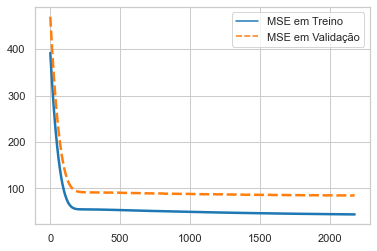

In [35]:
#Plot
sns.set(style = 'whitegrid')
sns.lineplot(data = df, palette = 'tab10', linewidth = 2.5)

In [38]:
#Previsões com o modelo treinado
previsoes = modelo.predict(x_teste).flatten()

4/4 [==============================] - 0s 1ms/step


In [39]:
#Imprime as previsões
previsoes

array([20.939468, 18.466125, 23.938015, 21.354748, 20.609688, 20.707401,
       24.548717, 21.947128, 21.098251, 20.902828, 25.898373, 23.46167 ,
       21.311996, 22.759361, 23.290672, 21.653988, 27.064812, 23.388386,
       29.562584, 20.005093, 20.475334, 21.04329 , 19.272251, 20.939468,
       19.040184, 23.547169, 22.905933, 14.356101, 17.275253, 35.41922 ,
       21.531849, 18.301235, 20.053951, 22.838753, 31.693935, 24.353294,
       21.849415, 28.109112, 25.80066 , 32.365707, 27.675514, 30.747349,
       32.231354, 17.275253, 23.101353, 23.315102, 18.429482, 23.589916,
       37.428432, 35.559677, 18.227951, 34.94287 , 31.242016, 25.959442,
       23.681522, 22.838753, 26.173187, 27.9259  , 24.762466, 24.377724,
       23.21128 , 19.13179 , 23.449455, 22.84486 , 21.141003, 20.273804,
       21.275356, 22.209728, 21.690632, 21.599026, 27.119774, 24.878498,
       10.948382, 14.075177, 17.189758, 23.388386, 17.574501, 18.05085 ,
       23.425026, 21.544064, 20.279911, 26.002193, 